# Distribution B - Maximum Likelihood - In X

In [188]:
import DistExampB as db

import sympy as sp
import cvxpy as cp

from matplotlib import pyplot as plot
from numpy import sinc
from sympy import Symbol, integrate, lambdify

from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
from Sinc import InterpZ

## Basic Setup

In [189]:
nSamp = 400

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

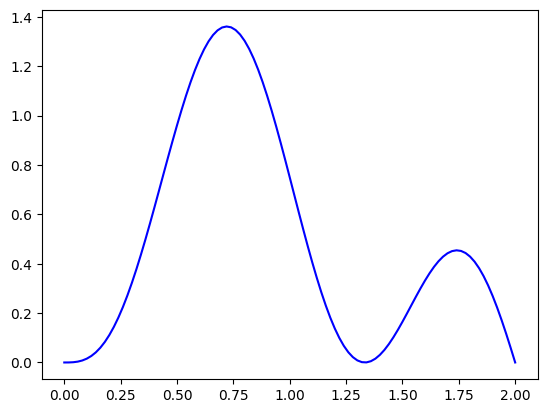

In [190]:
xGrid = Grid1(0,2, nPlot)
pdfX = tuple(dist.Pdf(x) for x in xGrid)

plot.plot(xGrid,pdfX, c='blue')

In [191]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

sampX = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 286


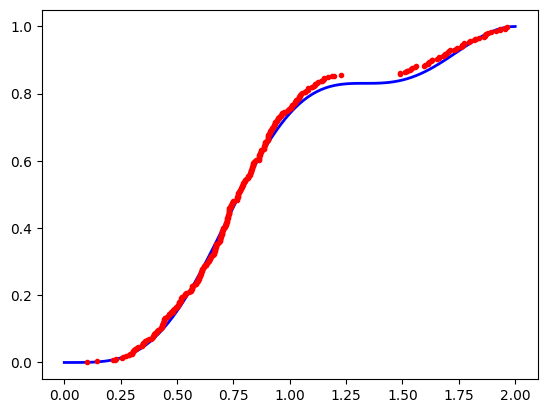

In [192]:
plot.plot(sampX,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Change of Variable

In [193]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [194]:
map_.forSym

log(x/(2 - x))

In [195]:
sampZ = tuple(map_.Forward(x) for x in sampX)

In [196]:
zMin,zMax = MinMax(sampZ)
zMin,zMax

(-2.931722055682509, 3.9711031313738383)

In [197]:
phiPrimeSym = (1 / map_.forSym.diff(xSym)).factor()
phiPrimeX = lambdify(xSym, phiPrimeSym)
phiPrimeSym

-x*(x - 2)/2

## Maximize Log-Likelihood for Sinc Approx of PDF(x)

In [198]:
nSinc = 11
sincZ = Grid1(zMin,zMax, nSinc)
sincX = tuple(map_.Inverse(z) for z in sincZ)
h = (zMax - zMin) / (nSinc - 1)

In [199]:
nSinc, h

(11, 0.6902825187056347)

In [200]:
sincVal = cp.Variable(nSinc)
sincVal

Variable((11,), var74325)

## Fit to Samples

In [201]:
phiX = lambdify(xSym, map_.forSym)
logLikeP = lambda x: (
	cp.log(sum(sv * sinc((phiX(x) - sz) / h) for (sz,sv) in zip(sincZ, sincVal))))
obj = cp.Maximize(sum(logLikeP(x) for x in sampX))

In [202]:
constEach = list(0 <= v for v in sincVal)
constArea = h * sum(v * phiPrimeX(x) for (x,v) in zip(sincX, sincVal)) == 1

const = constEach + [constArea]

In [203]:
prob = cp.Problem(obj, const)

In [204]:
prob.solve()

-91.28022514147654

In [205]:
sincV = list(sincVal.value)

In [206]:
h * sum(v * phiPrimeX(x) for (x,v) in zip(sincX,sincV))

0.9999999968475465

### Distribution Estimate on X

Text(0, 0.5, 'PDF')

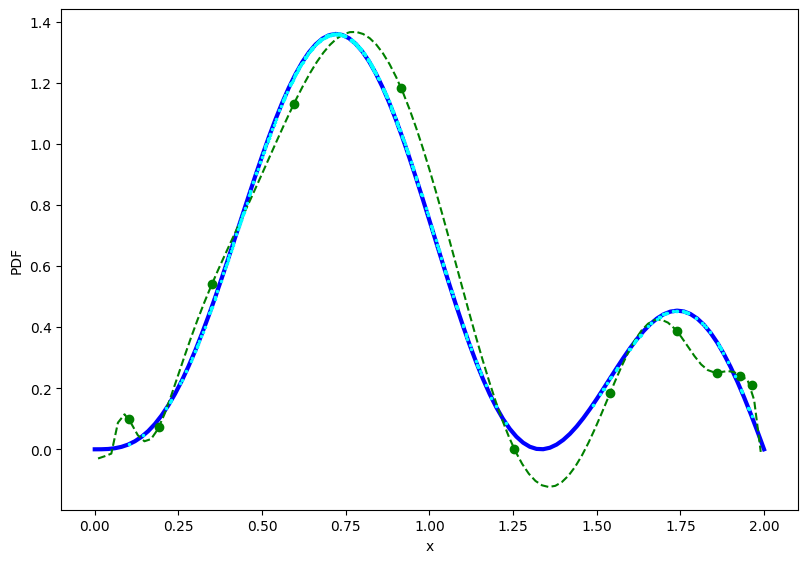

In [207]:
plot.subplots(figsize=(9.5, 6.5))

# show ture PDF in X
xGrid = Grid1(0,2, nPlot)
pdfX = tuple(dist.Pdf(x) for x in xGrid)
plot.plot(xGrid,pdfX, c='blue', linewidth=3)

# show the estiment of the PDF in X
plot.plot(sincX,sincV, 'o', c='green')

xGrid = tuple(2*(k + 0.5) / nPlot for k in range(nPlot))
zGrid = tuple(map_.Forward(x) for x in xGrid)
interpV = InterpZ(sincZ,sincV, zGrid)
plot.plot(xGrid,interpV, '--', c='green')

# # show samples
sampPdf = tuple(dist.Pdf(x) for x in sampX)
plot.plot(sampX,sampPdf, '.', c='cyan', markersize=3)

plot.xlabel('x')
plot.ylabel('PDF')